# Credit Card Default Prediction

## Overview
This notebook analyzes 30,000 credit card clients from Taiwan to predict who will default on their payment next month. I will compare 5 different classifiers and evaluate their performance using multiple metrics.

## Dataset
- **30,000 samples** (credit card clients)
- **23 features** (demographics, payment history, bill amounts)
- **Target**: Will the client default? (1 = Yes, 0 = No)
- **Class imbalance**: 78% non-defaults, 22% defaults

## Classifiers Used
I chose 5 classifiers to compare:
- **Logistic Regression** - Linear classifier that calculates probabilities
- **K-Nearest Neighbors (KNN)** - Classifies based on closest neighbors
- **Gaussian Naive Bayes** - Probabilistic classifier assuming normal distribution
- **Decision Tree** - Makes decisions through yes/no questions
- **Random Forest** - Combines multiple decision trees

### Why Gaussian Naive Bayes instead of Multinomial?
In Assignment 2, we used Multinomial Naive Bayes. However, that algorithm requires all values to be non-negative (it's designed for count data like word frequencies).

The credit card dataset contains negative values in some features (like payment history where -1 and -2 indicate different payment statuses), so MultinomialNB throws an error. **GaussianNB** works with continuous data including negative values, making it suitable for this dataset.

In [28]:
import io

import pandas as pd
import requests
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [29]:
url = 'https://raw.githubusercontent.com/Iliofotos/CreditCardDefaultPrediction/main/default_of_credit_card_clients.xls'
df = pd.read_excel(url, header=1, index_col=0)

## Why Scaled and Unscaled Comparison?

I ran the analysis on both unscaled and scaled data to demonstrate the impact of feature scaling.

**The Problem with Unscaled Data:**
The features in this dataset have very different scales:
- LIMIT_BAL (credit limit): ranges in thousands (e.g., 10,000 - 500,000)
- AGE: ranges in tens (e.g., 21 - 75)
- PAY_0 (payment status): ranges from -2 to 8

**Which Algorithms Are Affected:**
- **KNN**: Uses distance calculations - large-scale features dominate
- **Logistic Regression**: Struggles to optimize weights efficiently (convergence warning)
- **Decision Tree & Random Forest**: NOT affected - they only ask "is value > X?" and don't care about scale

**What I Expect:**
- KNN and Logistic Regression should improve after scaling
- Decision Tree and Random Forest should stay the same

This comparison helps demonstrate understanding of how different algorithms work and when preprocessing is necessary.

In [30]:
#Here we rename the dataframe and assign it to df
df.rename(columns={'default payment next month': 'target'})
df = df.rename(columns={'default payment next month': 'target'})
input_features = list(df.columns[:-1])

#Here we create a list of the classifier we are going to use
classifiers = [LogisticRegression, KNeighborsClassifier, GaussianNB,
               DecisionTreeClassifier, RandomForestClassifier]

#This list is for the classifier that will be trained on unscaled data
models_unscaled = [
    LogisticRegression(max_iter=1000),
    KNeighborsClassifier(),
    GaussianNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier()
]
#This is for the classifier that will be trained on scaled data
models_scaled = [
    LogisticRegression(max_iter=1000),
    KNeighborsClassifier(),
    GaussianNB(),
    DecisionTreeClassifier(),
    RandomForestClassifier()
]

## Train/Test Split
I chose a 70/30 split to give the models more training data (21,000 samples) while keeping enough test data (9,000 samples) for reliable evaluation.

In [31]:
#I wil be using only 30% of the data set for testing and the other 70% for training
PERCENTAGE_SAMPLES_USED_FOR_TESTING = 0.3

train, test = train_test_split(df, test_size=PERCENTAGE_SAMPLES_USED_FOR_TESTING, random_state=42)
print('We are using', len(train),'samples for training the', len(models_unscaled),'models and',len(test),'samples for testing them later.')

We are using 21000 samples for training the 5 models and 9000 samples for testing them later.


In [32]:
#Here we train our models on the unscaled data
for m in models_unscaled:
    m.fit(train[input_features], train['target'])
#And here we print out their accuracies
for m in models_unscaled:
    score = m.score(test[input_features], test['target'])
    print(str(m), ": ",score)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000) :  0.8081111111111111
KNeighborsClassifier() :  0.7533333333333333
GaussianNB() :  0.37777777777777777
DecisionTreeClassifier() :  0.7306666666666667
RandomForestClassifier() :  0.8146666666666667


In [33]:
#Here we are printing out each classifiers report
for m in models_unscaled:
    predictions = m.predict(test[input_features])
    print(f"\n{'='*50}")
    print(f"{m.__class__.__name__}")
    print(f"{'='*50}")
    print(f"Accuracy: {m.score(test[input_features], test['target']):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(test['target'], predictions):.4f}")
    print(classification_report(test['target'], predictions))


LogisticRegression
Accuracy: 0.8081
Balanced Accuracy: 0.6067
              precision    recall  f1-score   support

           0       0.82      0.96      0.89      7040
           1       0.66      0.25      0.36      1960

    accuracy                           0.81      9000
   macro avg       0.74      0.61      0.62      9000
weighted avg       0.79      0.81      0.77      9000


KNeighborsClassifier
Accuracy: 0.7533
Balanced Accuracy: 0.5441
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      7040
           1       0.36      0.17      0.23      1960

    accuracy                           0.75      9000
   macro avg       0.58      0.54      0.54      9000
weighted avg       0.70      0.75      0.72      9000


GaussianNB
Accuracy: 0.3778
Balanced Accuracy: 0.5599
              precision    recall  f1-score   support

           0       0.88      0.24      0.37      7040
           1       0.24      0.88      0.38      1960



Confusion Matrix for LogisticRegression Unscaled


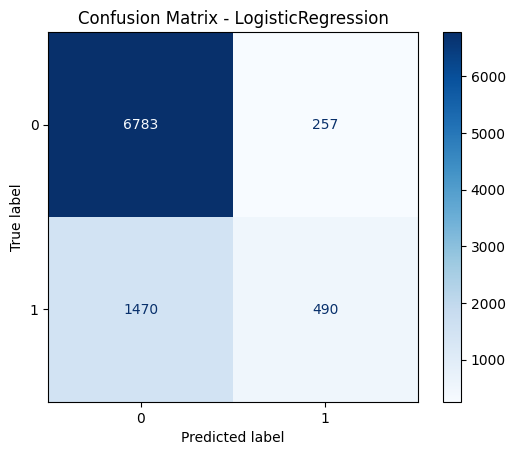


Confusion Matrix for KNeighborsClassifier Unscaled


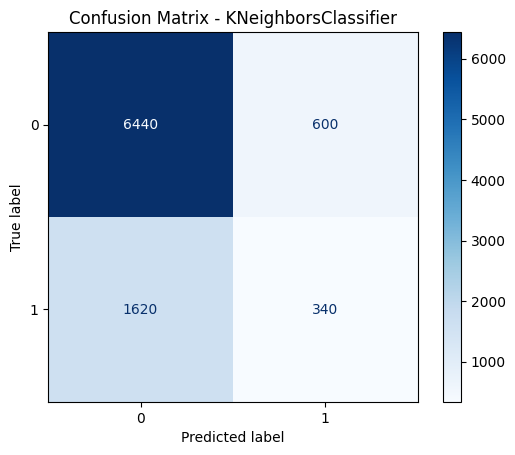


Confusion Matrix for GaussianNB Unscaled


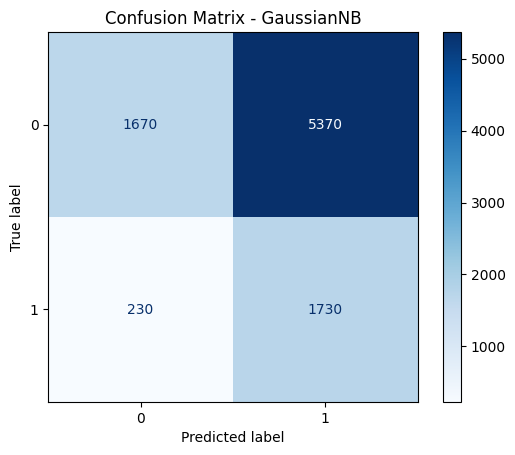


Confusion Matrix for DecisionTreeClassifier Unscaled


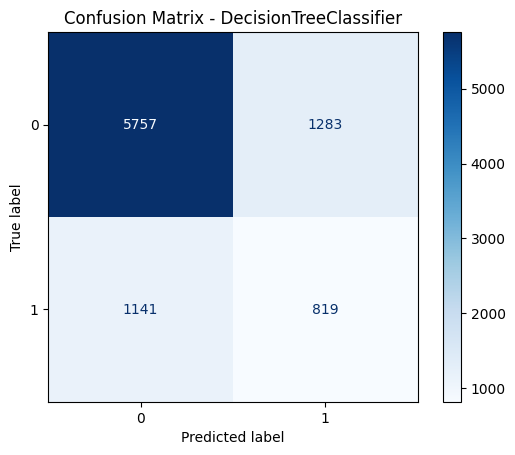


Confusion Matrix for RandomForestClassifier Unscaled


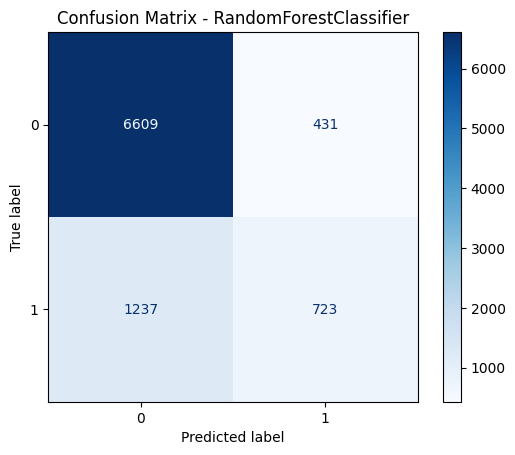

In [34]:
#Here we create the figure for the confusion matrix of the unscaled classifiers
for m in models_unscaled:
    print(f"\nConfusion Matrix for {m.__class__.__name__} Unscaled")
    ConfusionMatrixDisplay.from_estimator(
        m,
        test[input_features],
        test['target'],
        labels=m.classes_,
        cmap='Blues'
    )
    plt.title(f"Confusion Matrix - {m.__class__.__name__}")
    plt.show()

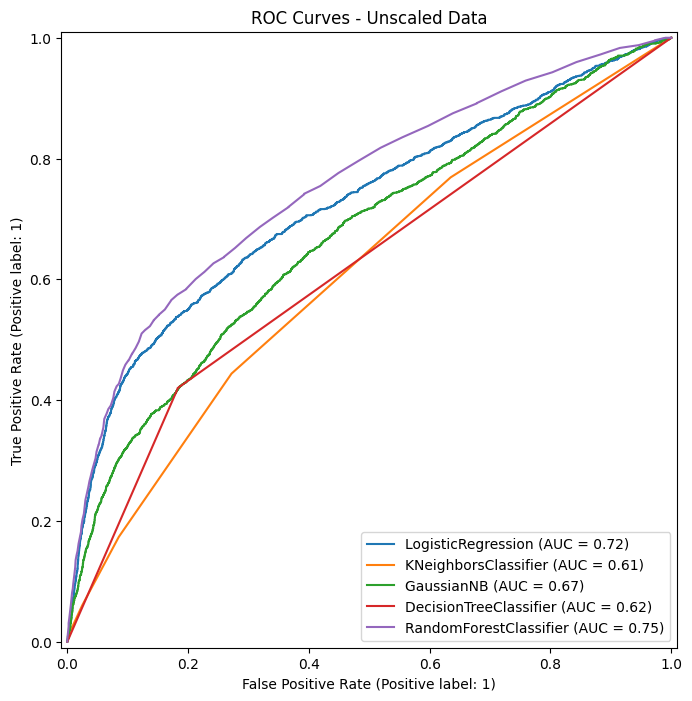

In [35]:
#In this section we calculate the ROC of each classifier and then use a graph to display them(Again for unscaled data)
fig, ax = plt.subplots(figsize=(10, 8))
for m in models_unscaled:
    RocCurveDisplay.from_estimator(m, test[input_features], test['target'], ax=ax, name=m.__class__.__name__)
plt.title("ROC Curves - Unscaled Data")
plt.show()

## Unscaled Results Analysis
The results show that accuracy alone is misleading due to class imbalance. A model predicting "no default" for everyone would get 78% accuracy.

Key observations:
- **RandomForest**: Best accuracy (82%) but only catches 39% of defaults
- **GaussianNB**: Worst accuracy (39%) but catches 86% of defaults
- **LogisticRegression**: Shows convergence warning due to unscaled features

## Scaling the Data
I applied StandardScaler to normalize all features. This should help KNN (which uses distance calculations) and Logistic Regression (which was showing convergence warnings).

In [36]:
#Here we scale our data to remove the error of the Logistic Regression but to also optimize the weright depened algorithms
#Then we train our clean models on the scaled data and display their balanced accuracies and their reports
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train[input_features])
X_test_scaled = scaler.transform(test[input_features])


y_train = train['target']
y_test = test['target']


for m in models_scaled:
    m.fit(X_train_scaled, y_train)

for m in models_scaled:
    predictions = m.predict(X_test_scaled)
    print(f"\n{'='*50}")
    print(f"{m.__class__.__name__}")
    print(f"{'='*50}")
    print(f"Accuracy: {m.score(X_test_scaled, y_test):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, predictions):.4f}")
    print(classification_report(y_test, predictions))


LogisticRegression
Accuracy: 0.8088
Balanced Accuracy: 0.6005
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      7040
           1       0.68      0.23      0.35      1960

    accuracy                           0.81      9000
   macro avg       0.75      0.60      0.62      9000
weighted avg       0.79      0.81      0.77      9000


KNeighborsClassifier
Accuracy: 0.7933
Balanced Accuracy: 0.6303
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      7040
           1       0.54      0.34      0.42      1960

    accuracy                           0.79      9000
   macro avg       0.69      0.63      0.65      9000
weighted avg       0.77      0.79      0.78      9000


GaussianNB
Accuracy: 0.6918
Balanced Accuracy: 0.6793
              precision    recall  f1-score   support

           0       0.88      0.70      0.78      7040
           1       0.38      0.66      0.48      1960



Confusion Matrix for LogisticRegression Scaled


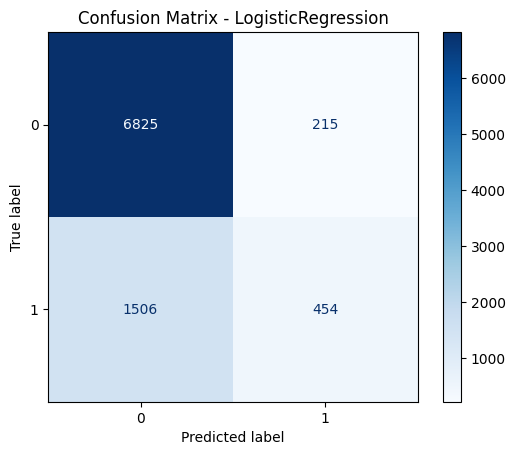


Confusion Matrix for KNeighborsClassifier Scaled


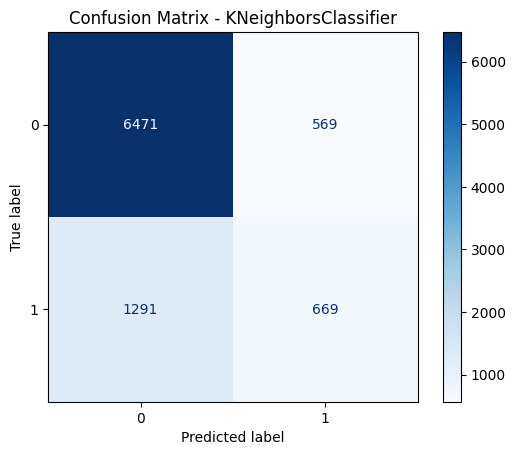


Confusion Matrix for GaussianNB Scaled


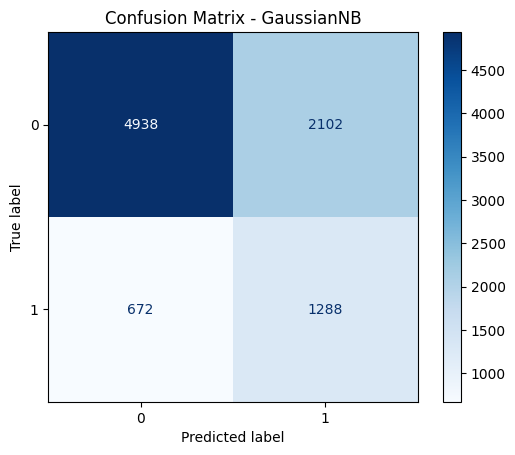


Confusion Matrix for DecisionTreeClassifier Scaled


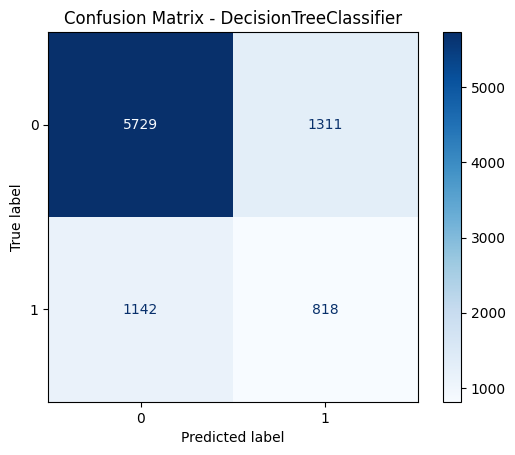


Confusion Matrix for RandomForestClassifier Scaled


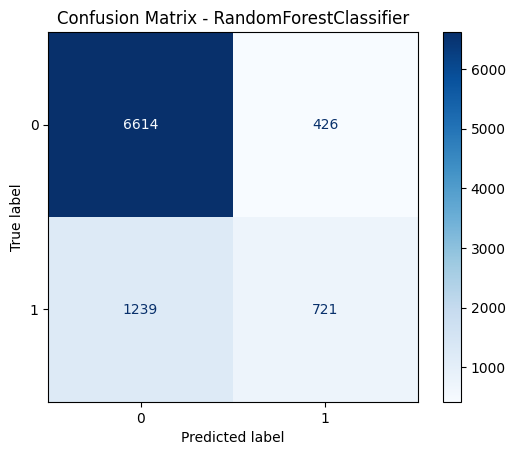

In [37]:
#Here we create a confusion matrix for the scaled models
for m in models_scaled:
    print(f"\nConfusion Matrix for {m.__class__.__name__} Scaled")
    ConfusionMatrixDisplay.from_estimator(
        m,
        X_test_scaled,
        y_test,
        labels=m.classes_,
        cmap='Blues'
    )
    plt.title(f"Confusion Matrix - {m.__class__.__name__}")
    plt.show()

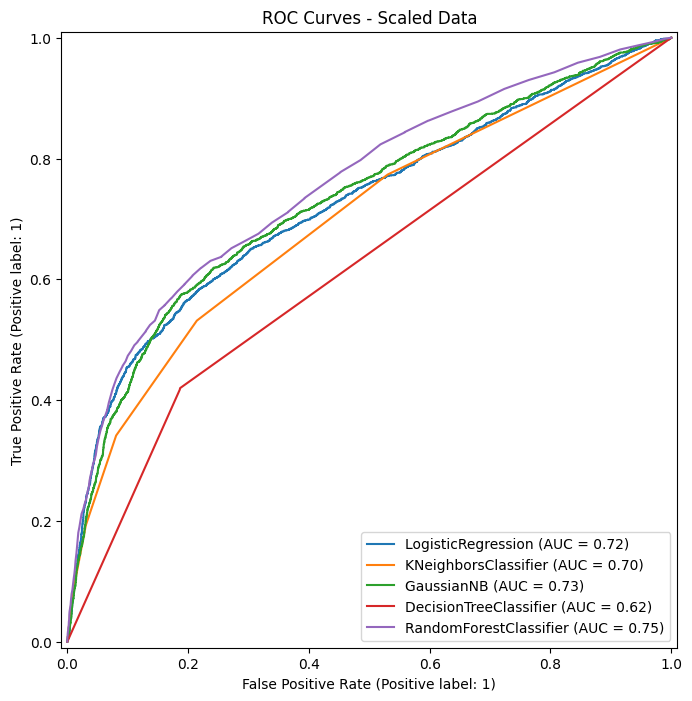

In [38]:
#And here we calculate the ROC for the Scaled data and display it

fig, ax = plt.subplots(figsize=(10, 8))
for m in models_scaled:
    RocCurveDisplay.from_estimator(m, X_test_scaled, y_test, ax=ax, name=m.__class__.__name__)
plt.title("ROC Curves - Scaled Data")
plt.show()

In [39]:
print("COMPARISON (Unscaled → Scaled)")
names = ['LogisticRegression', 'KNeighborsClassifier', 'GaussianNB', 'DecisionTreeClassifier', 'RandomForestClassifier']
for i, name in enumerate(names):
    pred_un = models_unscaled[i].predict(test[input_features])
    pred_sc = models_scaled[i].predict(X_test_scaled)
    ba_un = balanced_accuracy_score(test['target'], pred_un)
    ba_sc = balanced_accuracy_score(y_test, pred_sc)
    print(f"{name}: {ba_un*100:.1f}% → {ba_sc*100:.1f}%")

COMPARISON (Unscaled → Scaled)
LogisticRegression: 60.7% → 60.1%
KNeighborsClassifier: 54.4% → 63.0%
GaussianNB: 56.0% → 67.9%
DecisionTreeClassifier: 61.8% → 61.6%
RandomForestClassifier: 65.4% → 65.4%


## Conclusion
**RandomForest** performed best overall with the highest ROC-AUC (0.75). However, the best model depends on business needs - if catching all defaults is critical, GaussianNB's higher recall might be preferred despite lower accuracy.